In [1]:
# Tiina Manninen
# Implementation of astrocyte model by De Pitta et al. (2009)
# De Pitta, M., Goldberg, M., Volman, V., Berry, H., and Ben-Jacob, E. (2009). 
# Glutamate regulation of calcium and IP3 oscillating and pulsating dynamics in 
# astrocytes. J. Biol. Phys. 35, 383–411.
# Erratum available: De Pitta, M., Goldberg, M., Volman, V., Berry, H., and Ben-Jacob, E. 
# (2010). J. Biol. Phys. 36, 221–222.

# Model implemented and ran using Jupyter Notebook.

# Model code used in publication: Manninen, T., Havela, R., and Linne, M.-L. (2017). 
# Reproducibility and comparability of computational models for astrocyte calcium excitability.
# Front. Neuroinform.

import numpy as np

class ModelSystem:
    def __init__(self, params, stim):
        self.params = params
        self.stim = stim
    
    def computeDeriv(self, state, t):
        Ca, h, IP3 = state
        modelPar = self.params
        modelStim = self.stim
        
        # Intermediate variables
        J_leak = modelPar.r_L * (modelPar.Ca_free - (1 + modelPar.c_1) * Ca)
        J_pump = modelPar.v_ER * Ca ** 2 / (Ca ** 2 + modelPar.K_ER ** 2)
        
        K_gamma = modelPar.K_R * (1 + modelPar.K_p / modelPar.K_R * Ca / (Ca + modelPar.K_pi))
        m_infty = IP3 / (IP3 + modelPar.d_1)
        n_infty = Ca / (Ca + modelPar.d_5)
        Q_2 = modelPar.d_2 * (IP3 + modelPar.d_1) / (IP3 + modelPar.d_3)
        tau_h = 1 / (modelPar.a_2 * (Q_2 + Ca))
        v_3K = modelPar.v_bar_3K * Ca ** 4 / (Ca ** 4 + modelPar.K_D ** 4) * IP3 / (IP3 + modelPar.K_3)
        v_delta = modelPar.v_bar_delta / (1 + IP3/modelPar.kappa_delta) \
                * Ca ** 2 / (Ca ** 2 + modelPar.K_PLCdelta ** 2)
        v_glu = modelPar.v_bar_beta * modelStim(t) ** 0.7 / (modelStim(t) ** 0.7 + K_gamma ** 0.7)
        h_infty = Q_2 / (Q_2 + Ca)        
        J_chan = modelPar.r_C * m_infty ** 3 * n_infty ** 3 * h ** 3 \
                * (modelPar.Ca_free - (1 + modelPar.c_1) * Ca)         
        
        # dx/dt 
        dCa_per_dt = J_chan + J_leak - J_pump
        dh_per_dt = (h_infty - h) / tau_h
        dIP3_per_dt = v_glu + v_delta - v_3K - modelPar.r_bar_5P * IP3
        
        deriv = [dCa_per_dt, dh_per_dt, dIP3_per_dt]
        return deriv  

In [2]:
class ModelParameters:
    a_2 = 0.2          # 1/(uM s)
    c_1 = 0.185        # 1
    Ca_free = 2        # uM
    d_1 = 0.13         # uM
    d_2 = 1.049        # uM
    d_3 = 0.9434       # uM
    d_5 = 0.08234      # uM
    kappa_delta = 1.5  # uM
    K_3 = 1            # uM
    K_pi = 0.6         # uM 
    K_D = 0.7          # uM
    K_ER = 0.1         # uM or 0.05 uM
    K_p = 10           # uM
    K_PLCdelta = 0.1   # uM
    K_R = 1.3          # uM
    r_bar_5P = 0.04    # 1/s or 0.05 1/s
    r_C = 6            # 1/s
    r_L = 0.11         # 1/s
    v_bar_3K = 2       # uM/s
    v_bar_beta = 0.2   # uM/s or 0.5 uM/s
    v_bar_delta = 0.02 # uM/s or 0.05 uM/s
    v_ER = 0.9         # uM/s

In [3]:
def baseStim(t, minGlu = 2e-3, maxGlu = 5, duration = 62.5, period = 125, peaks = 2, startTime = 62.5):
    if (t < startTime):
        return minGlu
    if (t >= startTime + peaks * period):
        return minGlu
    
    # Compute phase
    ph = t - startTime
    ph -= np.floor(ph / period) * period
    
    if (ph < duration):
        return maxGlu
    
    return minGlu

In [4]:
params = ModelParameters()
modelStim_1 = lambda t: 1e-1    # uM
modelStim_2 = lambda t: 2.5     # uM
modelStim_3 = lambda t: 8       # uM
modelStim_4 = baseStim          # uM
modelStim_5 = lambda t: baseStim(t, duration = 5, period = 15, peaks = 7, startTime = 100)   # uM
modelStim_6 = lambda t: baseStim(t, duration = 1, period = 6, peaks = 7, startTime = 100)    # uM

mySys_1 = ModelSystem(params, modelStim_1)
mySys_2 = ModelSystem(params, modelStim_2)
mySys_3 = ModelSystem(params, modelStim_3)
mySys_4 = ModelSystem(params, modelStim_4)
mySys_5 = ModelSystem(params, modelStim_5)
mySys_6 = ModelSystem(params, modelStim_6)

In [5]:
from scipy.integrate import odeint
initial = [0.09, 0.78, 0.22] # uM, 1, uM

Tmax = 300
dt = 0.1
t = np.arange(0,Tmax,dt)

data_1 = odeint(mySys_1.computeDeriv, initial, t)
data_2 = odeint(mySys_2.computeDeriv, initial, t)
data_3 = odeint(mySys_3.computeDeriv, initial, t)
data_4 = odeint(mySys_4.computeDeriv, initial, t) 
data_5 = odeint(mySys_5.computeDeriv, initial, t)
data_6 = odeint(mySys_6.computeDeriv, initial, t, hmax=0.0005)

Populating the interactive namespace from numpy and matplotlib


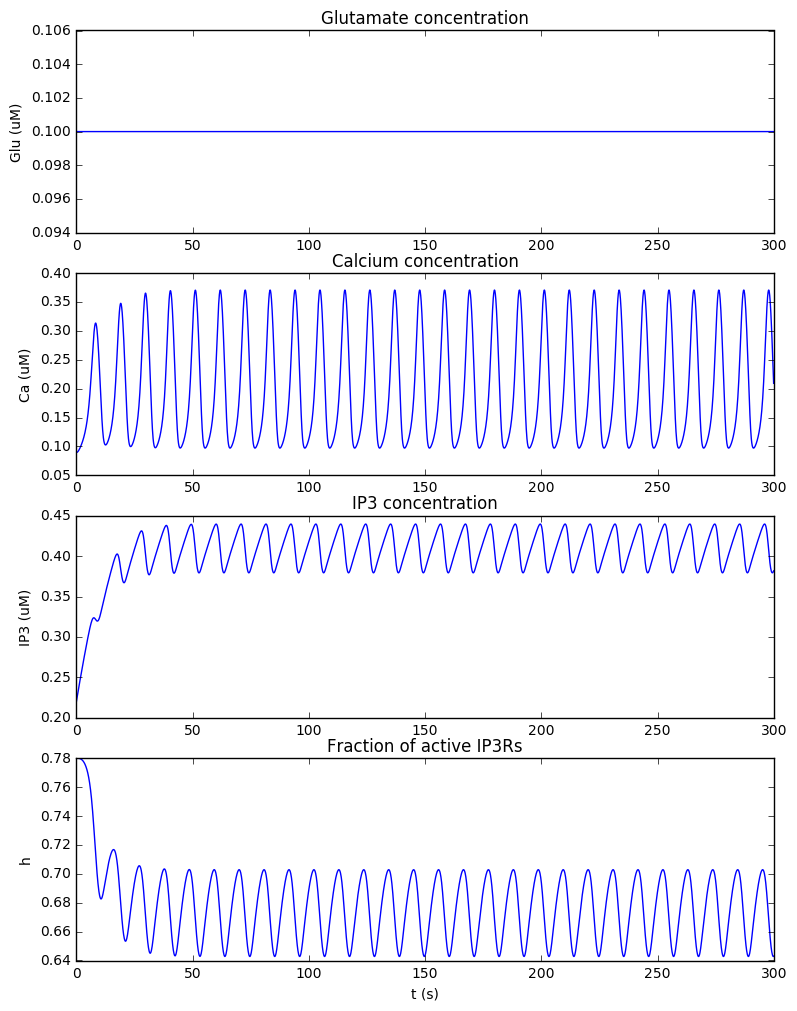

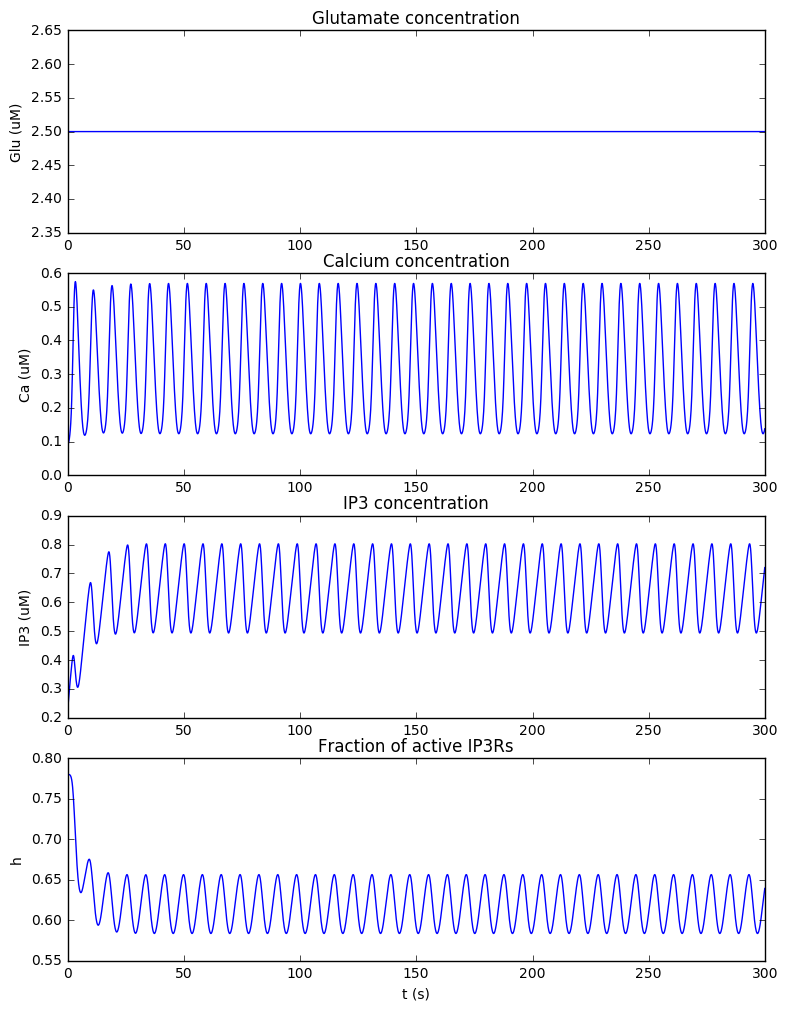

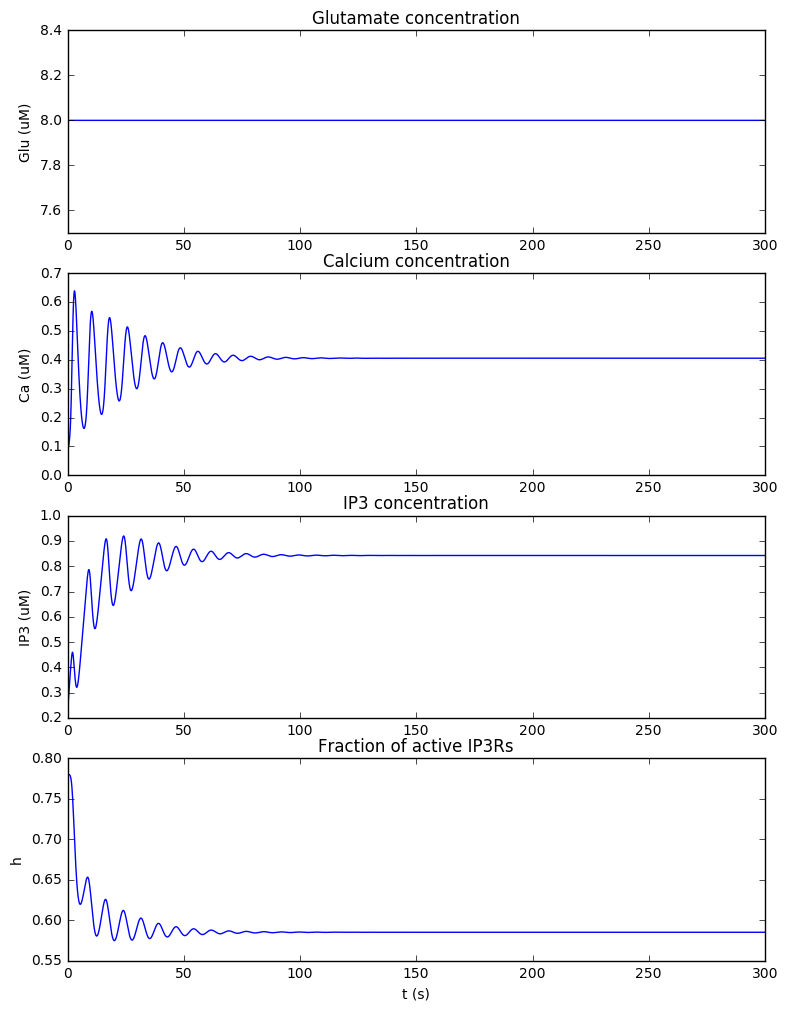

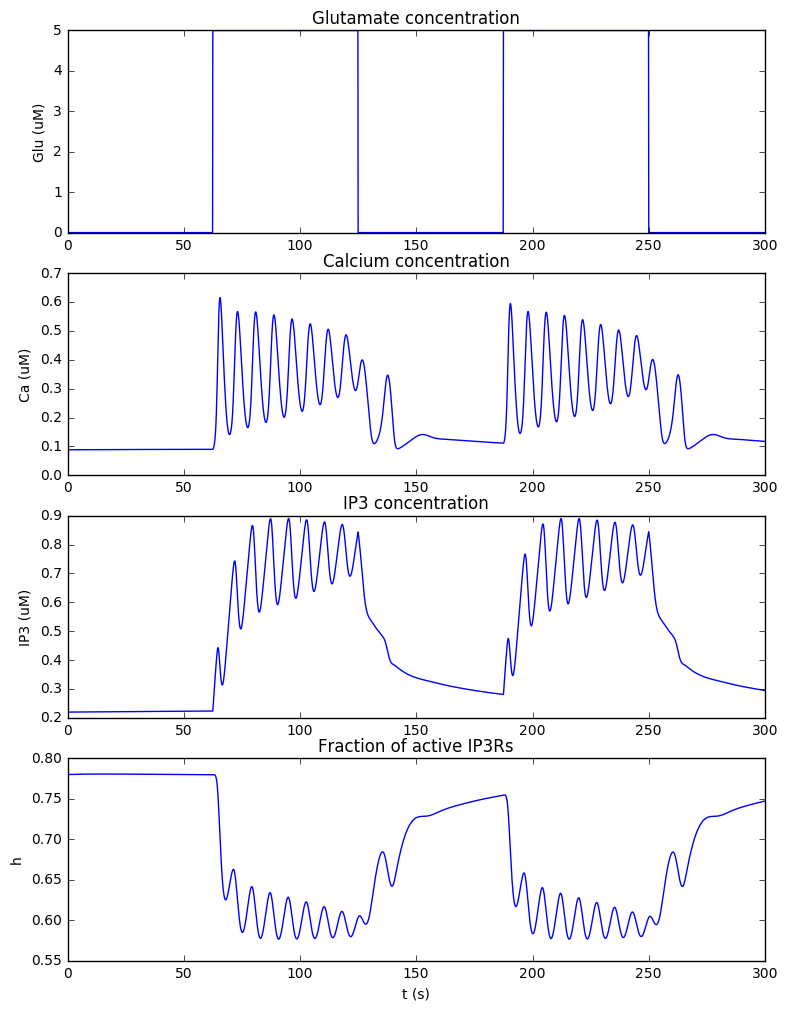

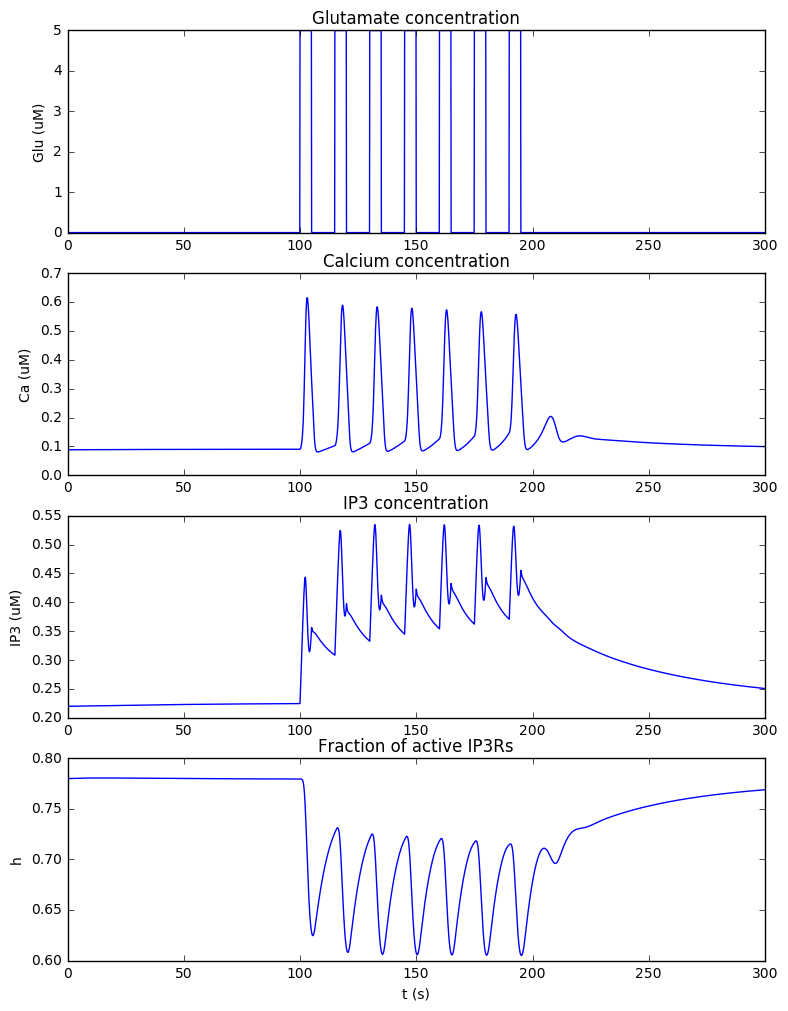

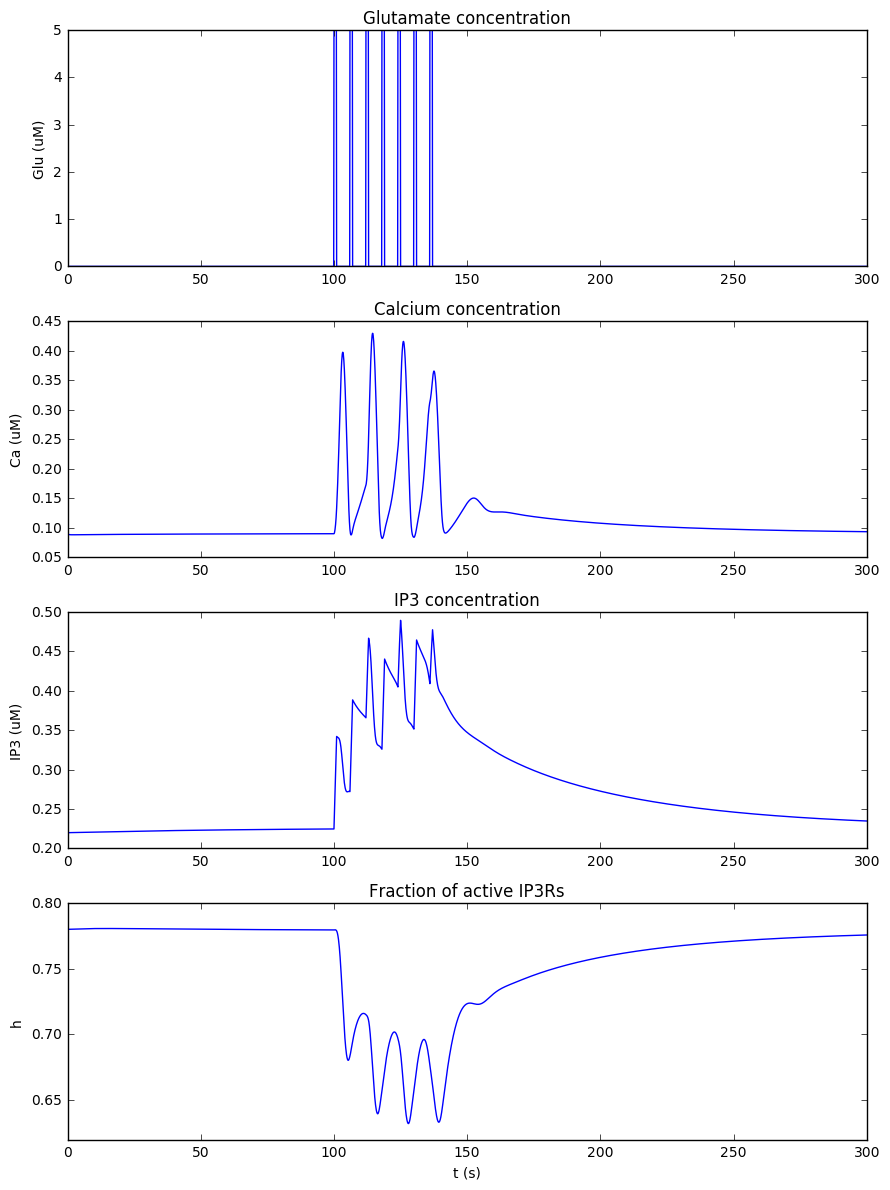

In [6]:
%pylab inline
import matplotlib.pyplot as plt

for pic in [(modelStim_1, data_1), (modelStim_2, data_2), (modelStim_3, data_3), (modelStim_4, data_4), (modelStim_5, data_5), (modelStim_6, data_6)]:
    modelStim_f, data_f = pic
    plt.figure(figsize=(9, 12), dpi=200)
    plt.subplot(4,1,1)
    plt.plot(t, list(map(modelStim_f, t)))
    plt.title('Glutamate concentration')
    plt.ylabel('Glu (uM)')

    plt.subplot(4,1,2)
    plt.plot(t, data_f[:,0])
    plt.title('Calcium concentration')
    plt.ylabel('Ca (uM)')

    plt.subplot(4,1,3)
    plt.plot(t, data_f[:,2])
    plt.title('IP3 concentration')
    plt.ylabel('IP3 (uM)')

    plt.subplot(4,1,4)
    plt.plot(t, data_f[:,1])
    plt.title('Fraction of active IP3Rs')
    plt.ylabel('h')
    plt.xlabel('t (s)')

plt.tight_layout()


np.savetxt('DePitta2009_constantstim_0_1uM.csv', (t, list(map(modelStim_1, t)), data_1[:,0], data_1[:,1], data_1[:,2]), delimiter=',')
np.savetxt('DePitta2009_constantstim_2_5uM.csv', (t, list(map(modelStim_2, t)), data_2[:,0], data_2[:,1], data_2[:,2]), delimiter=',')
np.savetxt('DePitta2009_constantstim_8uM.csv', (t, list(map(modelStim_3, t)), data_3[:,0], data_3[:,1], data_3[:,2]), delimiter=',')
np.savetxt('DePitta2009_originalstim.csv', (t, list(map(modelStim_4, t)), data_4[:,0], data_4[:,1], data_4[:,2]), delimiter=',')
np.savetxt('DePitta2009_pulsestim_5s_10s.csv', (t, list(map(modelStim_5, t)), data_5[:,0], data_5[:,1], data_5[:,2]), delimiter=',')
np.savetxt('DePitta2009_pulsestim_1s_5s.csv', (t, list(map(modelStim_6, t)), data_6[:,0], data_6[:,1], data_6[:,2]), delimiter=',')